In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import matplotlib

from itertools import permutations
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import tree

In [2]:
# Partition features
def used_together(partition, used):
    """Are the used members all in the same partition?"""
    p_list = partition.split("_")
    used_idx = [i for u in used for i, p in enumerate(p_list) if u in p]
    return all(used_idx[0] == pi for pi in used_idx)


def number_of_subsets(partition):
    """How many subsets are there in the partition?"""
    return int(len(partition.split("_")))


def used_isolated(partition, used):
    """Are the used members isolated from the unused members?"""
    p_list = partition.split("_")
    used_idx = [i for u in used for i, p in enumerate(p_list) if u in p]

    if all(i == used_idx[0] for i in used_idx) and len(p_list[used_idx[0]]) == len(
        used
    ):
        return True
    elif all(len(p_list[i]) == 1 for i in used_idx):
        return True

    return False

In [3]:
input = "/data/data-layout-benchmarks/260128/260128-10reps-vec"
df_vec = pd.read_csv(
    input, dtype={"problem_size": np.uintp, "container_byte_size": np.uintp}
)
df_vec["vectorized"] = True
assert df_vec.isna().sum().sum() == 0  # Check that there are no missing values

input = "/data/data-layout-benchmarks/260128/260128-10reps-novec"
df_novec = pd.read_csv(
    input, dtype={"problem_size": np.uintp, "container_byte_size": np.uintp}
)
df_novec["vectorized"] = False
assert df_novec.isna().sum().sum() == 0  # Check that there are no missing values

df_concat = pd.concat([df_vec, df_novec], ignore_index=True)
df_concat["n_subsets"] = df_concat["container"].apply(lambda c: number_of_subsets(c))

df_concat["used_members"] = df_concat["benchmark"].apply(
    lambda b: ["2", "3"] if b == "DeltaR2Pairwise" else ["1", "2", "3", "4"]
)
df_concat["used_together"] = [
    used_together(c, m)
    for c, m in zip(df_concat["container"], df_concat["used_members"])
]
df_concat["used_isolated"] = [
    used_isolated(c, m)
    for c, m in zip(df_concat["container"], df_concat["used_members"])
]

In [4]:
# Apply one hot encoding to the n_subsets column and keep the other columns unchanged
ct = ColumnTransformer(
    transformers=[("ohc", OneHotEncoder(sparse_output=False), ["n_subsets"])],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
ct.set_output(transform="pandas")
df = ct.fit_transform(df_concat)
df

,n_subsets_1,n_subsets_2,n_subsets_3,n_subsets_4,n_subsets_5,n_subsets_6,n_subsets_7,benchmark,container,problem_size,container_byte_size,time_unit,time,vectorized,used_members,used_together,used_isolated
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,InvariantMassSequential,PartitionedContainer0123456,91,16,ms,0.062111,True,"[1, 2, 3, 4]",True,False
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,InvariantMassSequential,PartitionedContainer0123456,91,16,ms,0.013580,True,"[1, 2, 3, 4]",True,False
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,InvariantMassSequential,PartitionedContainer0123456,91,16,ms,0.010900,True,"[1, 2, 3, 4]",True,False
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,InvariantMassSequential,PartitionedContainer0123456,91,16,ms,0.010681,True,"[1, 2, 3, 4]",True,False
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,InvariantMassSequential,PartitionedContainer0123456,91,16,ms,0.010600,True,"[1, 2, 3, 4]",True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2842675,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DeltaR2Pairwise,PartitionedContainer0_1_2_3_4_5_6,279620,64,ms,127.000000,False,"[2, 3]",False,True
2842676,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DeltaR2Pairwise,PartitionedContainer0_1_2_3_4_5_6,279620,64,ms,126.983000,False,"[2, 3]",False,True
2842677,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DeltaR2Pairwise,PartitionedContainer0_1_2_3_4_5_6,279620,64,ms,127.028000,False,"[2, 3]",False,True
2842678,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DeltaR2Pairwise,PartitionedContainer0_1_2_3_4_5_6,279620,64,ms,126.962000,False,"[2, 3]",False,True


In [5]:
feature_columns = [
    "vectorized",
    "used_together",
    "used_isolated",
    "n_subsets_1",
    "n_subsets_2",
    "n_subsets_3",
    "n_subsets_4",
    "n_subsets_5",
    "n_subsets_6",
    "n_subsets_7",
]

In [6]:
def kmeans_clustering_1D(data, n_clusters, xlabel="Data points", ylabel=""):
    reshaped_data = data.values.reshape(-1, 1)
    inertias = []
    max_k = 10
    for i in range(1, max_k):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(reshaped_data)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.subplot(121)
    plt.plot(range(1, max_k), inertias, marker="o")
    plt.title("Elbow method")
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")

    plt.subplot(122)
    plt.title(f"KMeans Clustering (k={n_clusters})")
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(reshaped_data)
    for label in np.unique(kmeans.labels_):
        plt.hist(
            data[kmeans.labels_ == label],
            alpha=0.5,
            bins="auto",
            label=f"Cluster {label}",
        )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale("log")
    plt.legend()

    plt.tight_layout()
    plt.show()
    return kmeans

In [7]:
def regression_tree_1D(df, target):
    features = df.groupby(["container"])[feature_columns].first()
    reg_tree = tree.DecisionTreeRegressor()
    reg_tree.fit(features, df.groupby(["container"])[target].mean().values)
    plt.figure(figsize=(26, 8))
    tree.plot_tree(
        reg_tree,
        fontsize=10,
        feature_names=feature_columns,
        filled=True,
    )
    plt.show()
    return reg_tree


def classification_tree_1D(X_train, X_test, Y_train, Y_test):
    class_tree = tree.DecisionTreeClassifier()
    class_tree.fit(X_train, Y_train)
    plt.figure(figsize=(26, 8))
    tree.plot_tree(
        class_tree,
        fontsize=10,
        feature_names=feature_columns,
        filled=True,
    )
    plt.show()

    #######

    plt.figure()
    ConfusionMatrixDisplay.from_estimator(class_tree, X_test, Y_test)
    plt.show()

    #######

    path = class_tree.cost_complexity_pruning_path(X_train, Y_train)
    cpp_alphas = path.ccp_alphas
    cpp_alphas = cpp_alphas[:-1]  # Exclude the maximum value which prunes everything

    cl_trees = []
    for ccp_a in cpp_alphas:
        cl_tree = tree.DecisionTreeClassifier(ccp_alpha=ccp_a)
        cl_tree.fit(X_train, Y_train)
        cl_trees.append(cl_tree)

    train_scores = [cl_tree.score(X_train, Y_train) for cl_tree in cl_trees]
    test_scores = [cl_tree.score(X_test, Y_test) for cl_tree in cl_trees]

    plt.figure()
    plt.xlabel("Alpha")
    plt.ylabel("Accuracy")
    plt.title(
        "Cost Complexity Pruning:\nAccuracy vs alpha for training and testing sets"
    )
    plt.plot(
        cpp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post"
    )
    plt.plot(cpp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
    plt.legend()
    plt.show()

    ########
    alpha_loop_values = []

    for ccp_a in cpp_alphas:
        clf_tree = tree.DecisionTreeClassifier(ccp_alpha=ccp_a)
        scores = cross_val_score(clf_tree, X_train, Y_train, cv=5)
        alpha_loop_values.append([ccp_a, np.mean(scores), np.std(scores)])

    alpha_loop_values = np.array(alpha_loop_values)
    plt.figure()
    plt.errorbar(
        alpha_loop_values[:, 0],
        alpha_loop_values[:, 1],
        yerr=alpha_loop_values[:, 2],
        marker="o",
        label="Mean Accuracy with Std Dev",
        ls="--",
    )
    plt.xlabel("Alpha")
    plt.ylabel("Cross-validated accuracy")
    plt.title("Cost Complexity Pruning:\nCross-validated accuracy vs alpha")
    plt.show()
    print("Alphas:", alpha_loop_values[:, 0])
    print("Best on average:", alpha_loop_values[np.argmax(alpha_loop_values[:, 1])])

    return class_tree

## Invariant Mass Random

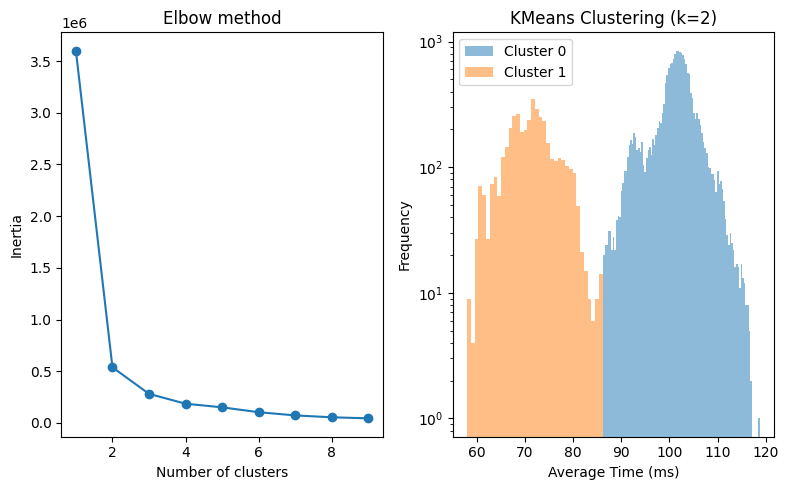

In [8]:
benchmark = "InvariantMassRandom"
problem_size = df["problem_size"].unique()[1]
df_imr = df[(df["benchmark"] == benchmark) & (df["problem_size"] == problem_size)]
data_imr = df_imr.groupby(["container"])["time"].mean()

kmeans_imr = kmeans_clustering_1D(
    data_imr, n_clusters=2, xlabel="Average Time (ms)", ylabel="Frequency"
)

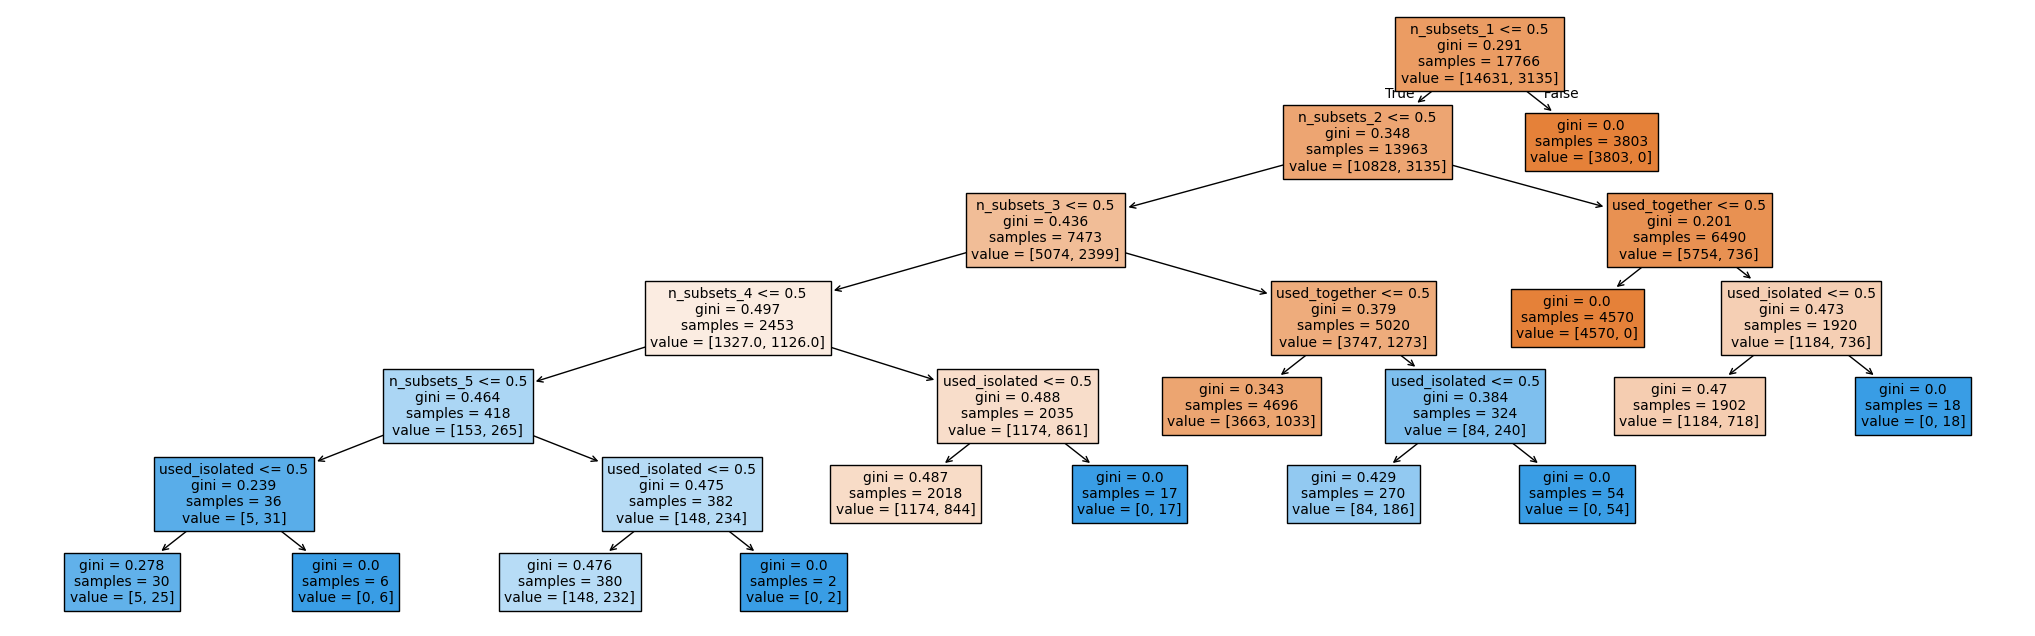

<Figure size 640x480 with 0 Axes>

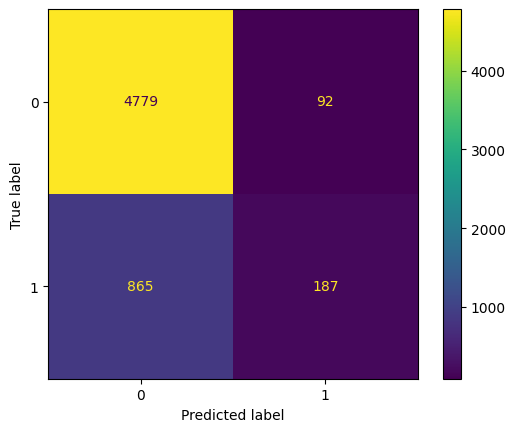

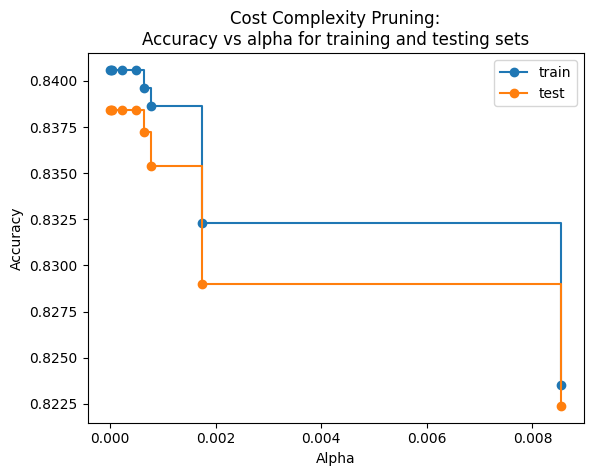

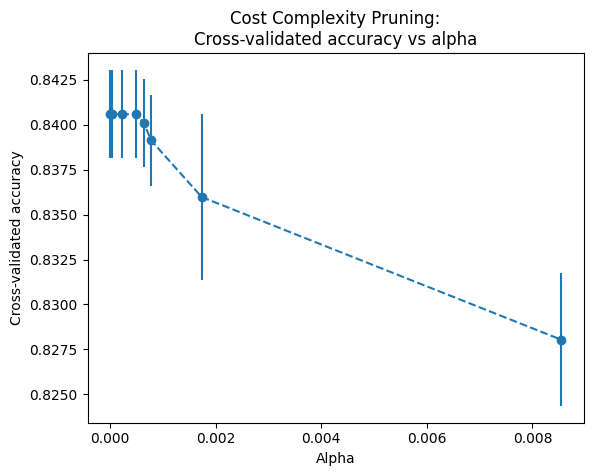

Alphas: [0.00000000e+00 1.56353584e-05 3.39740096e-05 2.28792777e-04
 4.90324840e-04 6.42302892e-04 7.77865494e-04 1.73594358e-03
 8.54138688e-03]
Best on average: [0.         0.8405945  0.00246361]


In [9]:
X_imr = df_imr.groupby(["container"])[feature_columns].first()
Y_imr = kmeans_imr.labels_
X_train_imr, X_test_imr, Y_train_imr, Y_test_imr = train_test_split(
    X_imr, Y_imr, shuffle=True
)

cl_tree_imr = classification_tree_1D(X_train_imr, X_test_imr, Y_train_imr, Y_test_imr)

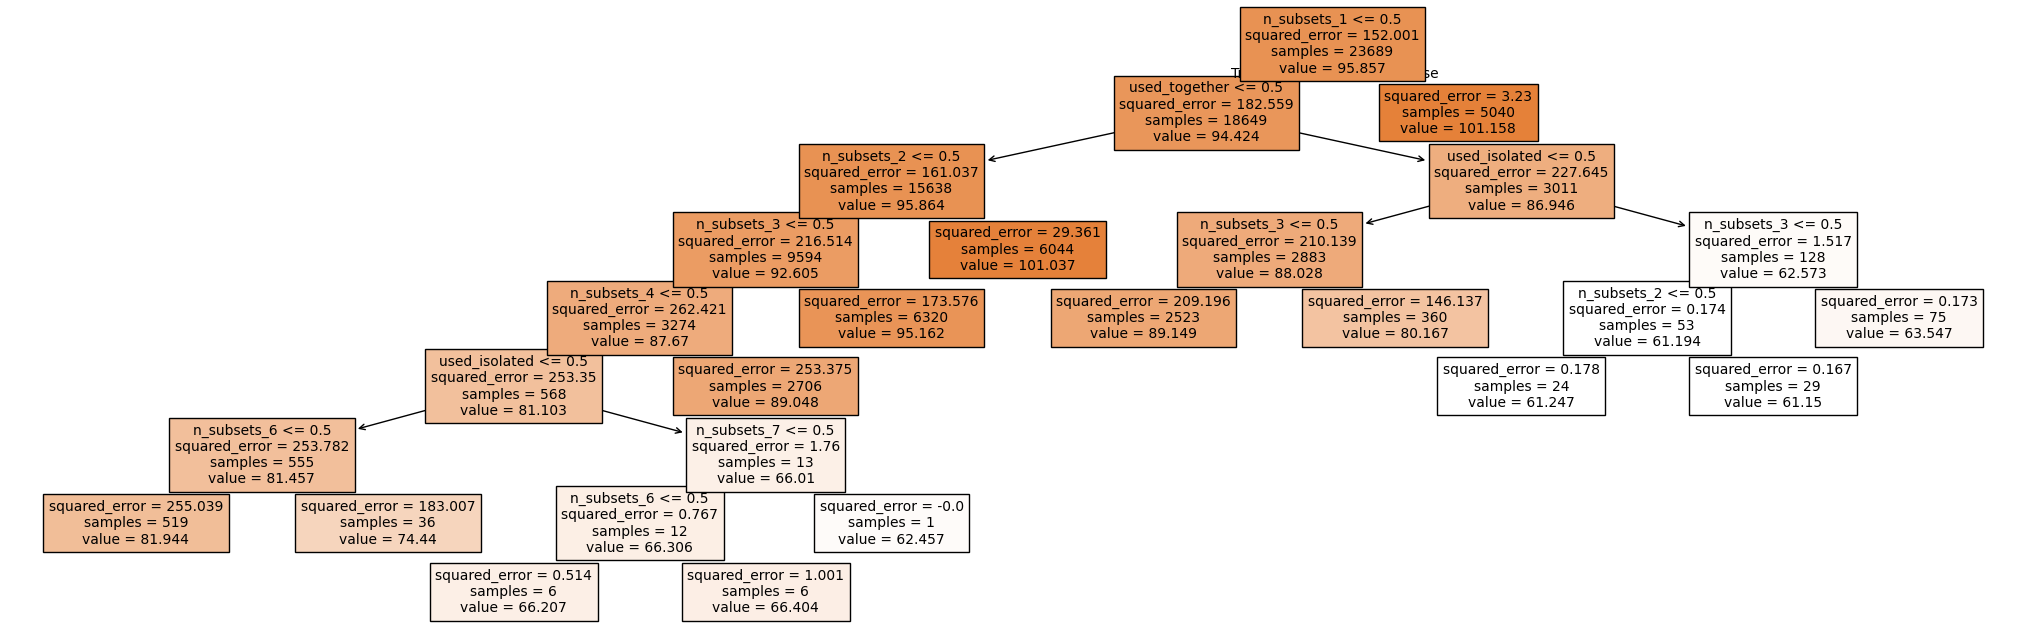

DecisionTreeRegressor()

In [10]:
regression_tree_1D(df_imr, target="time")

## InvariantMassSequential

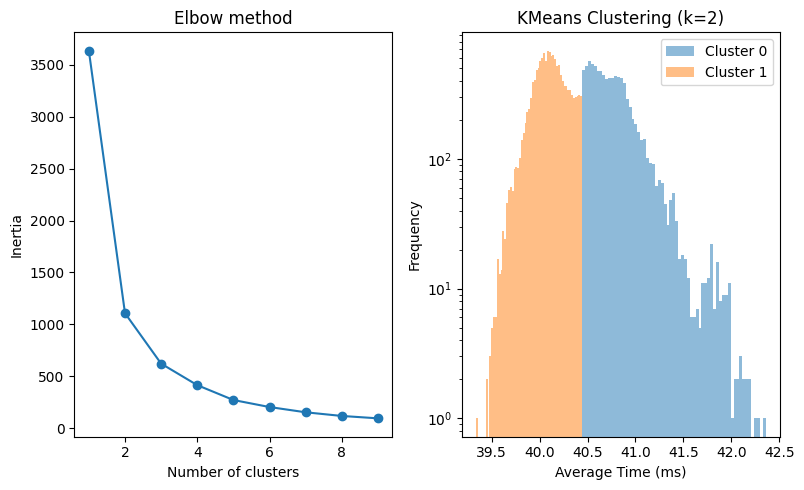

In [11]:
benchmark = "InvariantMassSequential"
problem_size = df["problem_size"].unique()[1]
df_ims = df[(df["benchmark"] == benchmark) & (df["problem_size"] == problem_size)]
data_ims = df_ims.groupby(["container"])["time"].min()

kmeans_ims = kmeans_clustering_1D(
    data_ims, n_clusters=2, xlabel="Average Time (ms)", ylabel="Frequency"
)

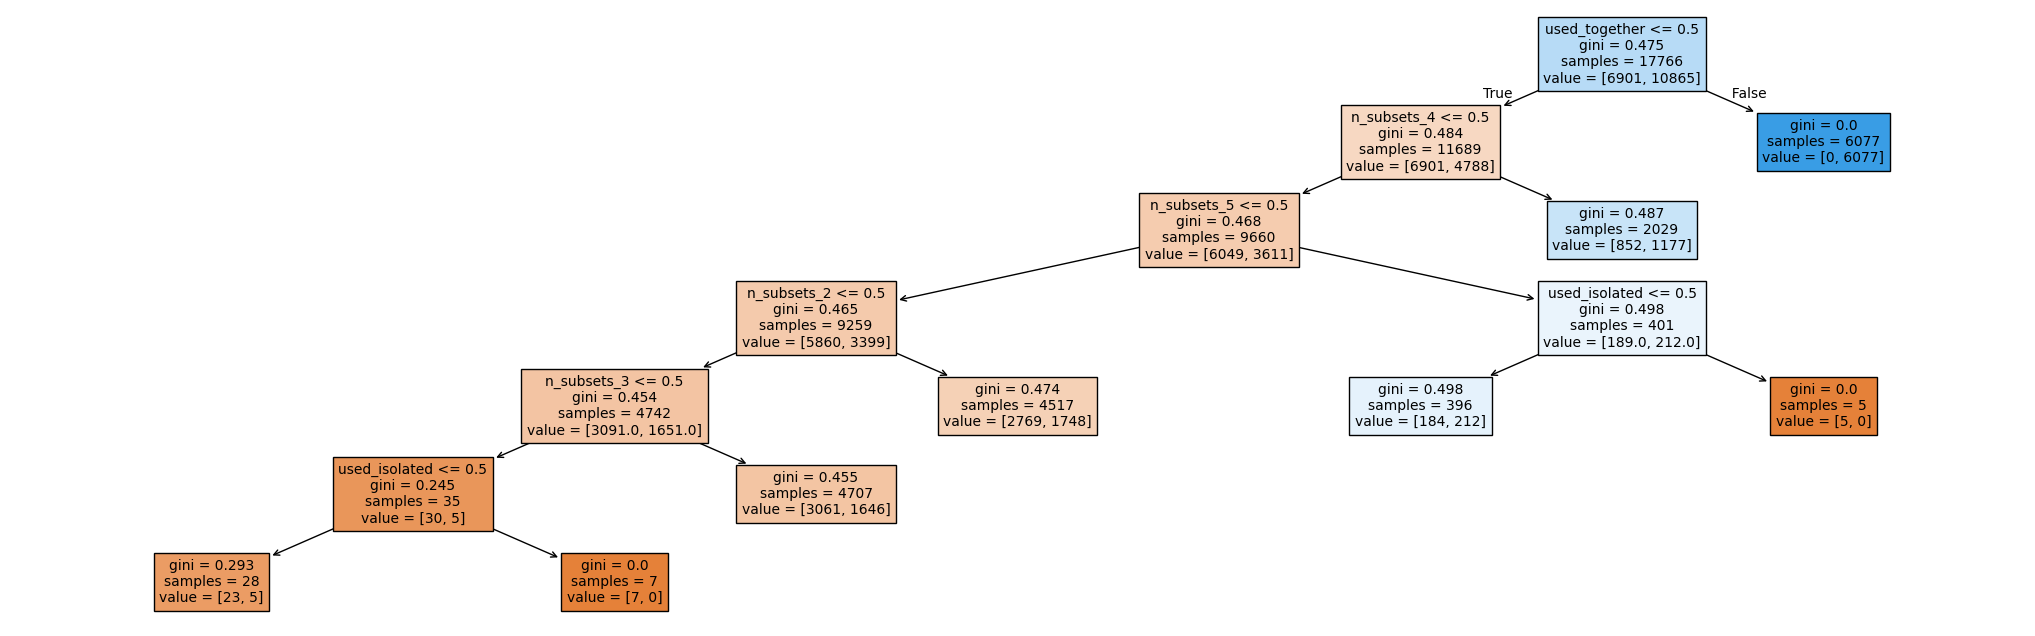

<Figure size 640x480 with 0 Axes>

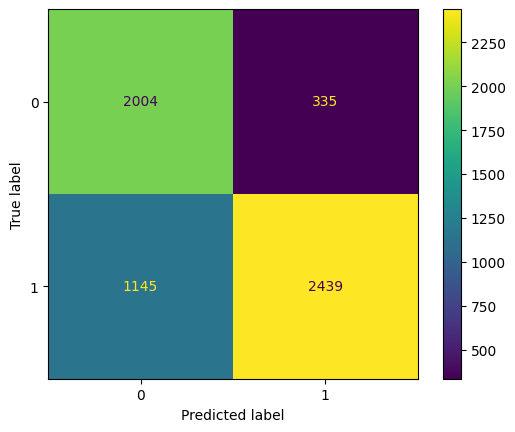

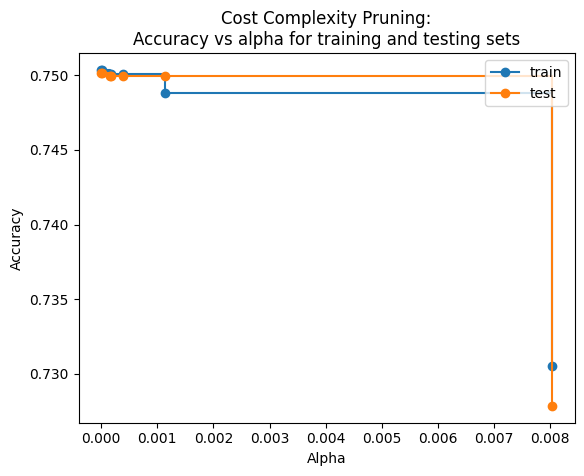

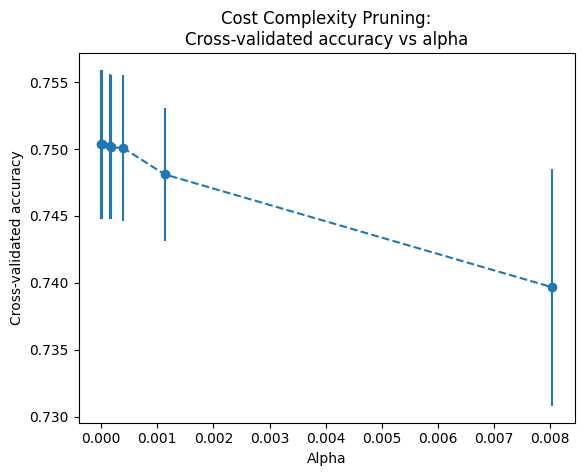

Alphas: [0.00000000e+00 2.01026037e-05 1.59309805e-04 1.67316309e-04
 3.92406185e-04 1.12960215e-03 8.03217176e-03]
Best on average: [0.         0.75036647 0.00555863]


In [12]:
X_ims = df_ims.groupby(["container"])[feature_columns].first()
Y_ims = kmeans_ims.labels_
X_train_ims, X_test_ims, Y_train_ims, Y_test_ims = train_test_split(
    X_ims, Y_ims, shuffle=True
)

cl_tree_ims = classification_tree_1D(X_train_ims, X_test_ims, Y_train_ims, Y_test_ims)

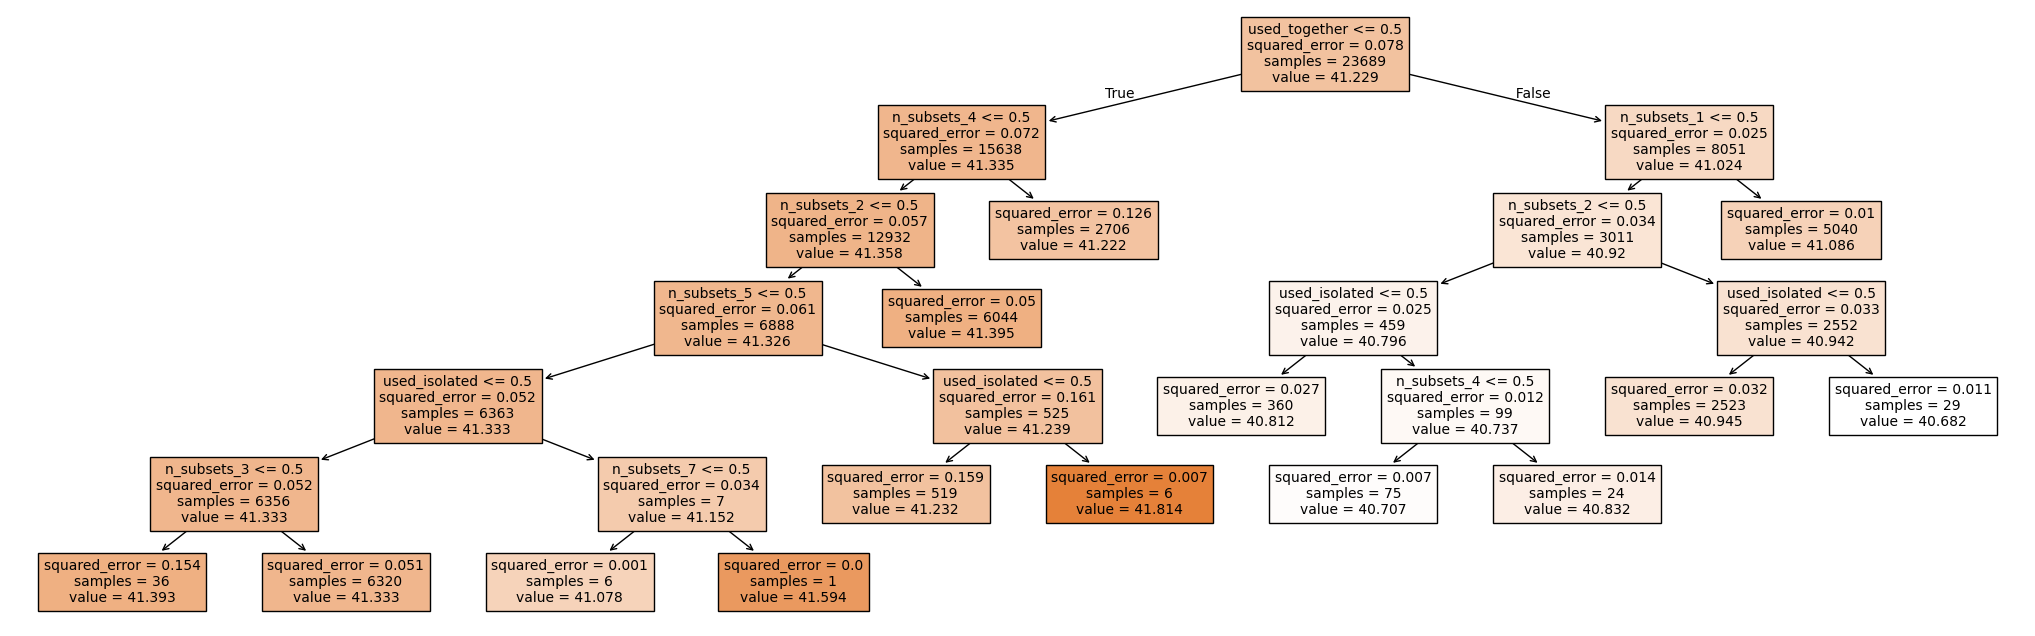

DecisionTreeRegressor()

In [13]:
regression_tree_1D(df_ims, target="time")

## DeltaR2Pairwise

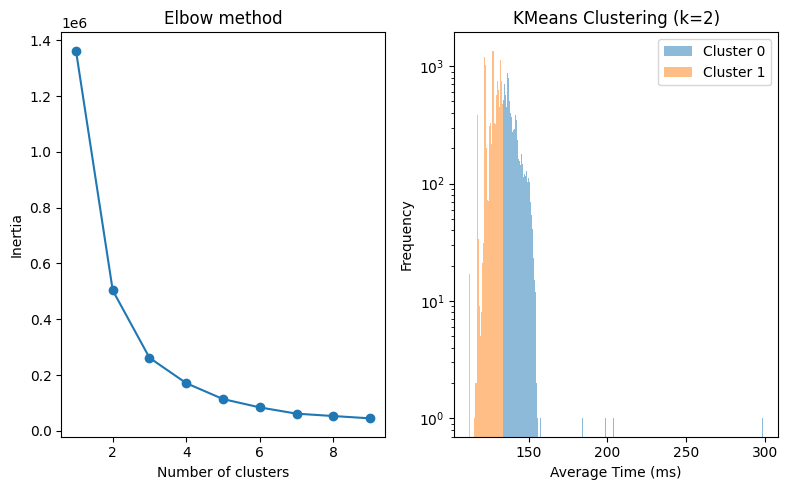

In [14]:
benchmark = "DeltaR2Pairwise"
problem_size = df["problem_size"].unique()[1]
df_dr2 = df[(df["benchmark"] == benchmark) & (df["problem_size"] == problem_size)]
data_dr2 = df_dr2.groupby(["container"])["time"].mean()

kmeans_dr2 = kmeans_clustering_1D(
    data_dr2, n_clusters=2, xlabel="Average Time (ms)", ylabel="Frequency"
)

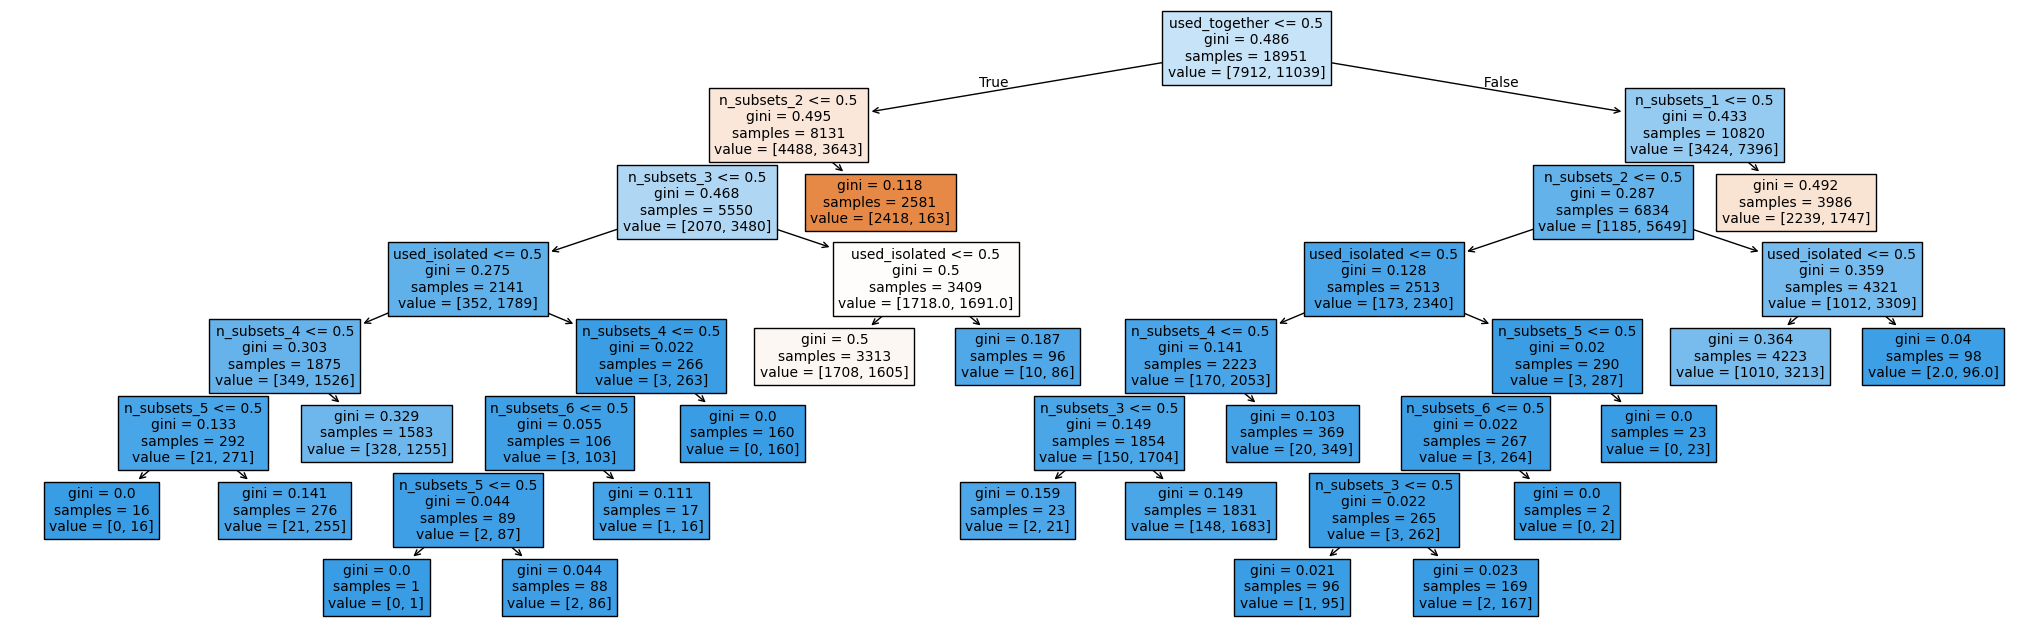

<Figure size 640x480 with 0 Axes>

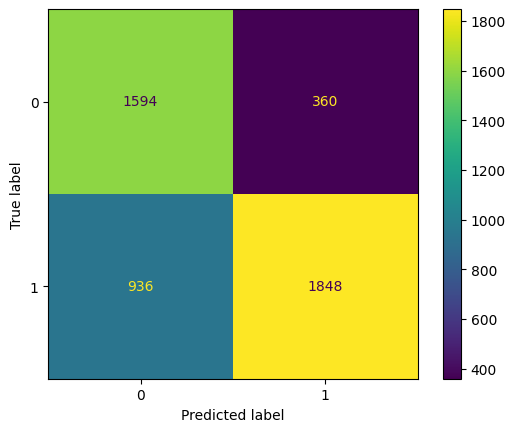

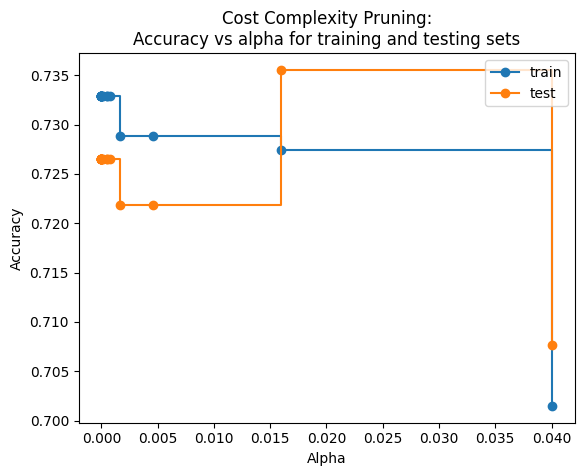

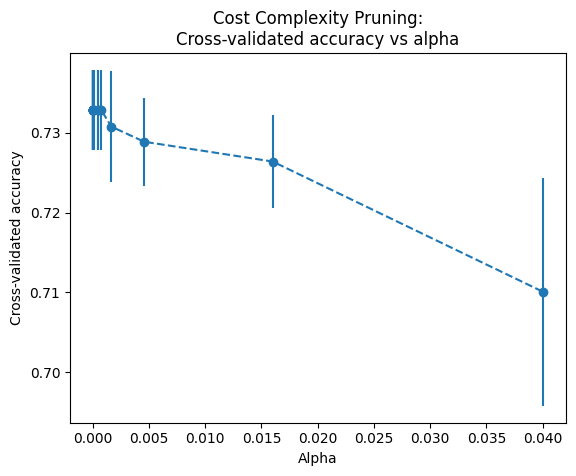

Alphas: [0.00000000e+00 1.29852323e-08 2.68480800e-08 5.38995546e-08
 8.99728269e-08 2.82136289e-07 1.99057456e-06 5.38980253e-06
 9.23984110e-06 2.31632450e-05 1.18391073e-04 4.76158295e-04
 4.83715338e-04 7.51659068e-04 1.66627235e-03 4.58539184e-03
 1.60014173e-02 4.00643925e-02]
Best on average: [0.         0.73288962 0.00499302]


In [15]:
X_dr2 = df_dr2.groupby(["container"])[feature_columns].first()
Y_dr2 = kmeans_dr2.labels_
X_train_dr2, X_test_dr2, Y_train_dr2, Y_test_dr2 = train_test_split(
    X_dr2, Y_dr2, test_size=0.2, random_state=42
)

cl_tree_dr2 = classification_tree_1D(X_train_dr2, X_test_dr2, Y_train_dr2, Y_test_dr2)

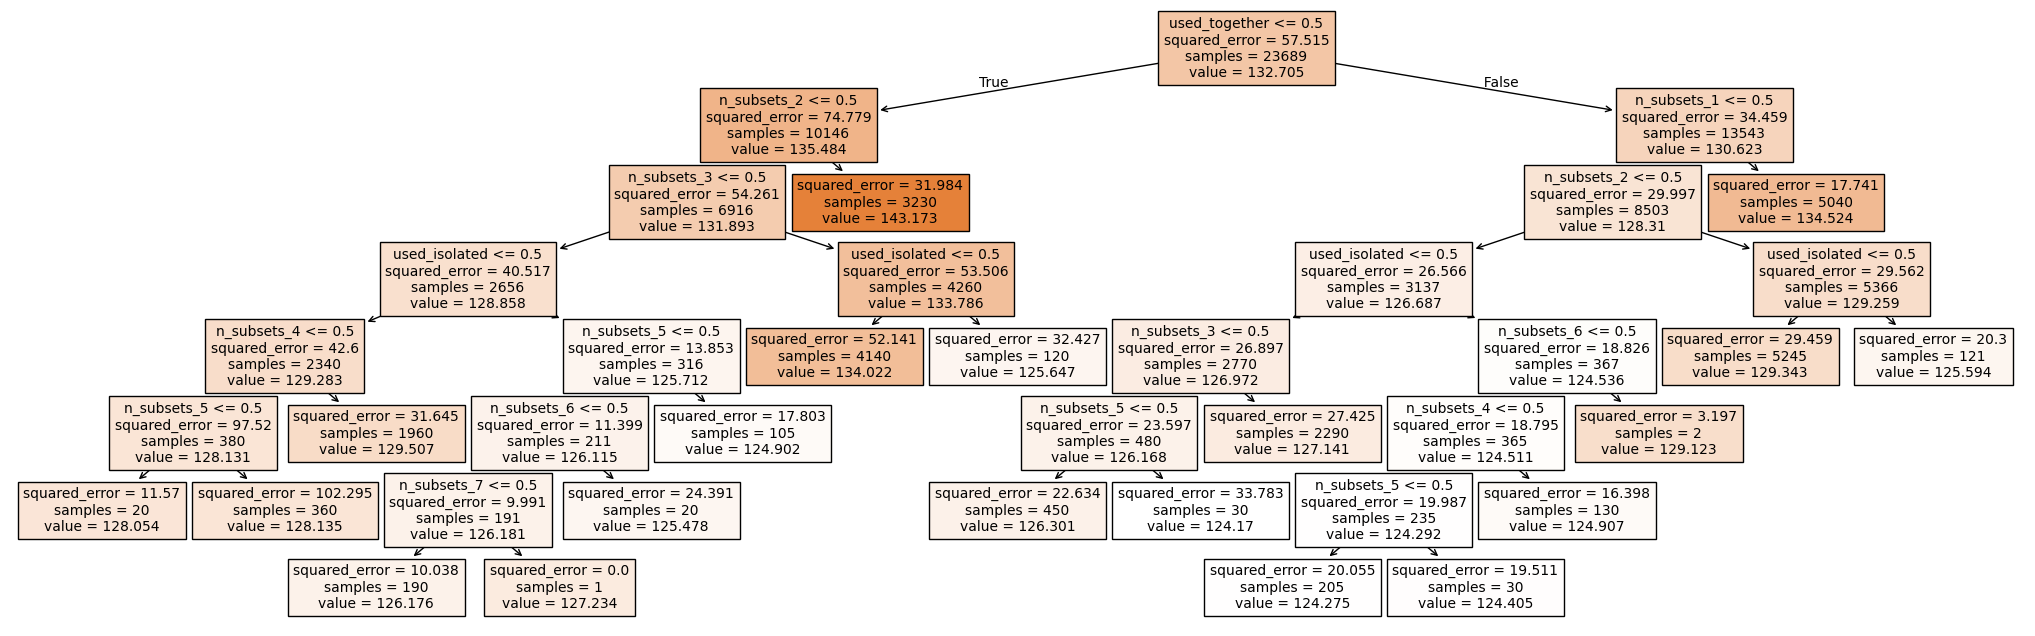

DecisionTreeRegressor()

In [16]:
regression_tree_1D(df_dr2, target="time")

## All Benchmarks

<function matplotlib.pyplot.show(block=None)>

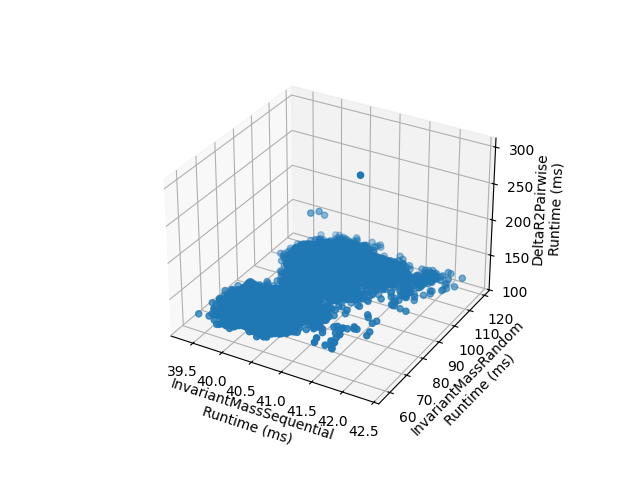

In [17]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data_ims, data_imr, data_dr2)
ax.set_xlabel('InvariantMassSequential\nRuntime (ms)')
ax.set_ylabel('InvariantMassRandom\nRuntime (ms)')
ax.set_zlabel('DeltaR2Pairwise\nRuntime (ms)')
plt.show

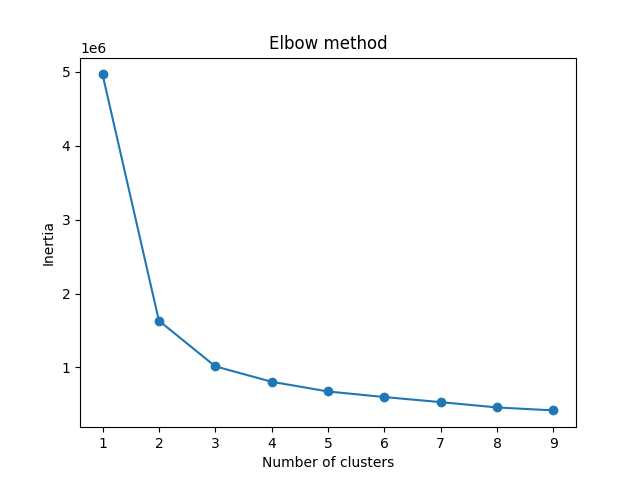

In [18]:
data_3d = np.hstack(
    (
        data_ims.values.reshape(-1, 1),
        data_imr.values.reshape(-1, 1),
        data_dr2.values.reshape(-1, 1),
    )
)

inertias = []
max_k = 10
for i in range(1, max_k):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data_3d)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, max_k), inertias, marker="o")
plt.title("Elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

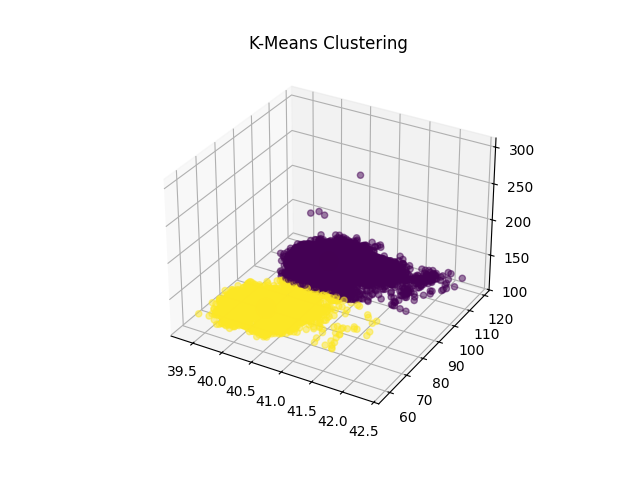

In [19]:
%matplotlib widget

kmeans = KMeans(n_clusters=2)
kmeans.fit(data_3d)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("K-Means Clustering")
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red', s=200, alpha=0.75, label='Centroids')
ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c=kmeans.labels_, alpha=0.5)
plt.show()